In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pennylane as qml
import random
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

In [2]:
# Set the random seed for reproducibility
seed = 24#23
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
def random_walk(samples, steps):
    positions = np.zeros(shape=(samples, 2))

    for step in range(steps):
        step = np.random.random(size=(samples, 2)) - 0.5
        norms = np.linalg.norm(step, axis=1)
        normalized_step = step/norms[:, np.newaxis]
        positions += normalized_step

    return positions
    
positions = random_walk(20000, 5).T

In [4]:
np.size(positions, axis=1)

20000

In [5]:
def calculate_probabilities(samples, batch_size, bins, steps):
    x_bins = np.linspace(-steps, steps, bins + 1)
    y_bins = np.linspace(-steps, steps, bins + 1)
    prob_map = []

    for i in range(int(np.size(samples, axis=1)/batch_size)):
        data = samples[:,i*batch_size:(i+1)*batch_size]
        map, _ , _ = np.histogram2d(data[0], data[1], bins=(x_bins, y_bins))
        prob_map.append(map)

    return np.array(prob_map)/batch_size
        
probs_map = calculate_probabilities(positions, 2000, 8, 5)

In [77]:
probs_map[0]

array([[0.    , 0.    , 0.    , 0.004 , 0.0005, 0.    , 0.    , 0.    ],
       [0.    , 0.001 , 0.0085, 0.0225, 0.015 , 0.009 , 0.0025, 0.    ],
       [0.    , 0.0085, 0.031 , 0.05  , 0.0405, 0.0295, 0.008 , 0.    ],
       [0.002 , 0.0155, 0.044 , 0.085 , 0.0765, 0.0475, 0.0165, 0.0005],
       [0.0025, 0.016 , 0.037 , 0.0705, 0.0755, 0.043 , 0.0105, 0.0005],
       [0.    , 0.0045, 0.034 , 0.042 , 0.043 , 0.0315, 0.008 , 0.0005],
       [0.    , 0.0025, 0.009 , 0.018 , 0.0155, 0.0095, 0.0025, 0.0005],
       [0.    , 0.    , 0.    , 0.0025, 0.002 , 0.001 , 0.    , 0.    ]])

In [7]:
class WalkDataset(Dataset):
    def __init__(self, probs):
        self.data = torch.tensor(probs, dtype=torch.float32) 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [8]:
# Create the data loader instance
dataset = WalkDataset(probs_map.reshape(10, 64))
dataloader = DataLoader(dataset, batch_size=1)

In [9]:
n_qubits = 6
n_a_qubits = 0
q_depth = 6 

In [10]:
# Discriminator implementation

class Discriminator(nn.Module):
    """Fully connected classical discriminator"""

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            # Inputs to first hidden layer (num_input_features -> 64)
            nn.Linear(64, 100),
            nn.ReLU(),
            # First hidden layer (64 -> 16)
            nn.Linear(100, 20),
            nn.ReLU(),
            # Second hidden layer (16 -> output)
            nn.Linear(20, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        
        return self.model(x)


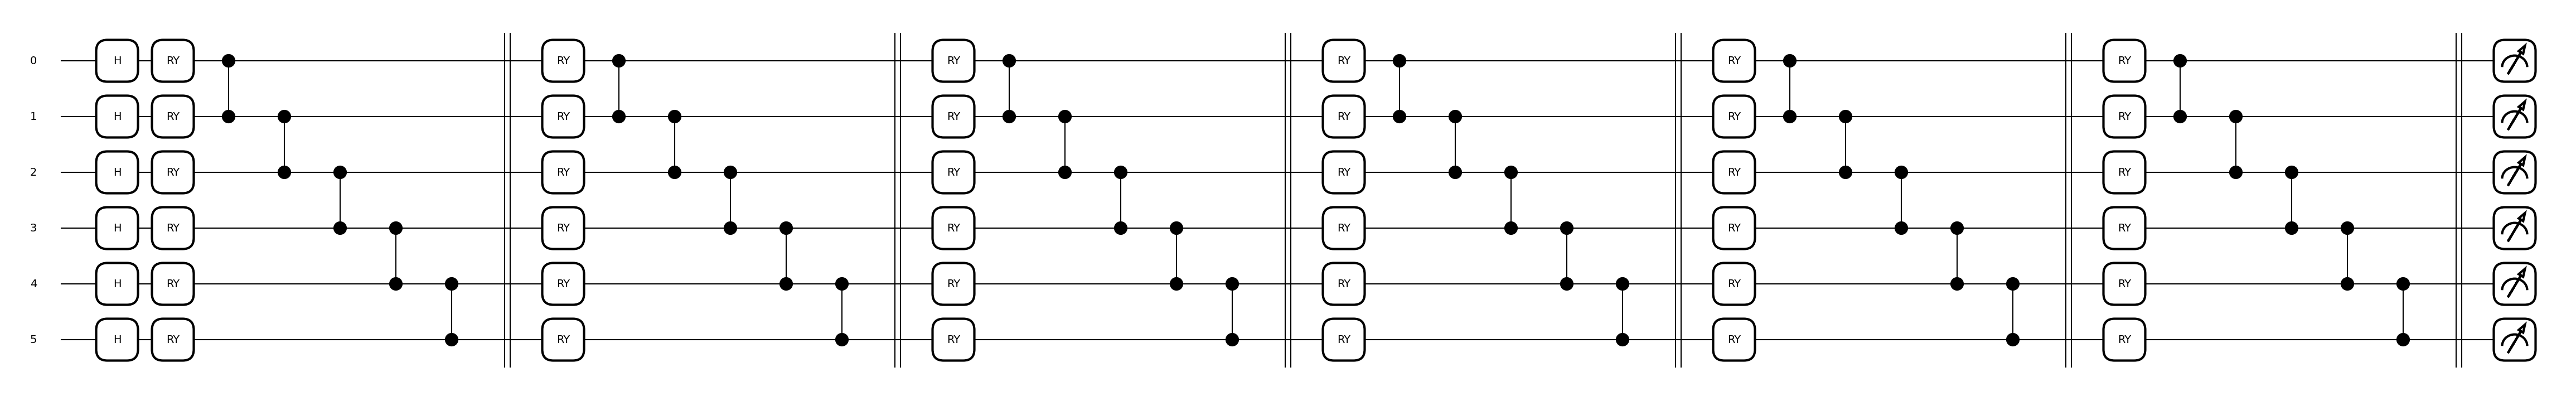

In [11]:
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

@qml.qnode(dev, diff_method="backprop")
def quantum_circuit(weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

        #qml.CZ(wires=[5, 0])

        qml.Barrier(wires=list(range(n_qubits)), only_visual=True)

    return qml.probs(wires=list(range(n_qubits)))

noise = torch.rand(1, n_qubits, device=device) 
weights = torch.rand(1, n_qubits*q_depth) 

qml.draw_mpl(quantum_circuit)(weights=weights)
plt.show()

In [12]:
def partial_measure(weights):
    # Non-linear Transform
    probs = quantum_circuit(weights)
    probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
    probsgiven0 /= torch.sum(probs)

    return probsgiven0

In [13]:
class QuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""

    def __init__(self):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
        """

        super().__init__()

        self.q_params = nn.ParameterList(
            [
                nn.Parameter(torch.rand(q_depth * n_qubits), requires_grad=True)
            ]
        )

    def forward(self):

        qc_out = quantum_circuit(self.q_params[0]).float().unsqueeze(0)
        
        return qc_out
        

In [14]:
discriminator = Discriminator().to(device)
generator = QuantumGenerator().to(device)

In [15]:
lrG = 0.3  # Learning rate for the generator
lrD = 0.01  # Learning rate for the discriminator
num_iter = 500  # Number of training iterations

In [16]:
# Binary cross entropy
criterion = nn.BCELoss()

# Optimisers
optD = optim.SGD(discriminator.parameters(), lr=lrD)
optG = optim.SGD(generator.parameters(), lr=lrG)

real_labels = torch.full((1,), 1.0, dtype=torch.float, device=device)
fake_labels = torch.full((1,), 0.0, dtype=torch.float, device=device)

# Fixed noise allows us to visually track the generated images throughout training
fixed_noise = torch.rand(1, n_qubits, device=device) * np.pi / 2

# Iteration counter
counter = 0

# Collect images for plotting later
disc_loss = []
gen_loss = []

In [17]:
for i, data in enumerate(dataloader):
    #data = data.reshape(-1, data.size(0))
    real_data = data.to(device)

    #noise = torch.rand(1, n_qubits, device=device) * np.pi / 2
    fake_data = generator()

    discriminator.zero_grad()
    outD_real = discriminator(real_data).view(-1)
    outD_fake = discriminator(fake_data.detach()).view(-1)

In [18]:
while True:
    for i, data in enumerate(dataloader):

        # Data for training the discriminator
        #data = data.reshape(-1, data.size(0))
        real_data = data.to(device)

        # Noise follwing a uniform distribution in range [0,pi/2)
        noise = torch.rand(1, n_qubits, device=device) * np.pi / 2
        fake_data = generator()

        # Training the discriminator
        discriminator.zero_grad()
        outD_real = discriminator(real_data).view(-1)
        outD_fake = discriminator(fake_data.detach()).view(-1)

        errD_real = criterion(outD_real, real_labels)
        errD_fake = criterion(outD_fake, fake_labels)
        # Propagate gradients
        errD_real.backward()
        errD_fake.backward()

        errD = errD_real + errD_fake
        

        optD.step()
        

        # Training the generator
        generator.zero_grad()
        outD_fake = discriminator(fake_data).view(-1)
        errG = criterion(outD_fake, real_labels)
        

        errG.backward()
        optG.step()

        

    # Show loss values
    if counter % 10 == 0:
        print(f'Iteration: {counter}, Discriminator Loss: {errD:0.3f}, Generator Loss: {errG:0.3f}')
        gen_loss.append(errG.detach())
        disc_loss.append(errD.detach())

    counter += 1
    if counter == num_iter:
        break

Iteration: 0, Discriminator Loss: 1.388, Generator Loss: 0.776
Iteration: 10, Discriminator Loss: 1.383, Generator Loss: 0.737
Iteration: 20, Discriminator Loss: 1.383, Generator Loss: 0.716
Iteration: 30, Discriminator Loss: 1.384, Generator Loss: 0.704
Iteration: 40, Discriminator Loss: 1.386, Generator Loss: 0.699
Iteration: 50, Discriminator Loss: 1.385, Generator Loss: 0.699
Iteration: 60, Discriminator Loss: 1.381, Generator Loss: 0.701
Iteration: 70, Discriminator Loss: 1.380, Generator Loss: 0.701
Iteration: 80, Discriminator Loss: 1.381, Generator Loss: 0.698
Iteration: 90, Discriminator Loss: 1.383, Generator Loss: 0.696
Iteration: 100, Discriminator Loss: 1.383, Generator Loss: 0.697
Iteration: 110, Discriminator Loss: 1.383, Generator Loss: 0.696
Iteration: 120, Discriminator Loss: 1.383, Generator Loss: 0.696
Iteration: 130, Discriminator Loss: 1.382, Generator Loss: 0.697
Iteration: 140, Discriminator Loss: 1.379, Generator Loss: 0.698
Iteration: 150, Discriminator Loss: 

# Test

In [19]:
t = generator().detach().numpy()
t = t.reshape(8, 8)
t

array([[9.3177217e-04, 2.2151590e-04, 7.7096265e-05, 3.3706505e-04,
        1.1672530e-03, 2.5802867e-05, 5.0562299e-05, 6.4438733e-04],
       [2.6026581e-05, 2.7043584e-03, 1.0277211e-02, 1.3384118e-02,
        2.7330736e-02, 1.1835023e-02, 3.0092287e-03, 2.7984631e-04],
       [2.5404201e-04, 9.0300757e-03, 2.4844069e-02, 4.2727068e-02,
        5.4352451e-02, 2.8855301e-02, 5.2488972e-03, 8.0462231e-04],
       [9.3039806e-04, 7.9396926e-03, 4.1618772e-02, 7.7493206e-02,
        8.9854389e-02, 5.0957579e-02, 1.6312877e-02, 9.2241527e-05],
       [6.7879388e-05, 1.0823726e-02, 3.3148095e-02, 7.4213915e-02,
        7.5393438e-02, 4.9773812e-02, 1.0831480e-02, 1.2706309e-04],
       [1.8827349e-03, 3.2198047e-03, 2.1586204e-02, 5.1441416e-02,
        4.8383720e-02, 3.3615578e-02, 1.1607018e-02, 7.4061065e-04],
       [8.5137476e-04, 1.0743215e-03, 5.1645366e-03, 1.8151915e-02,
        8.7739090e-03, 8.8296654e-03, 2.6205694e-03, 2.2795366e-04],
       [6.0626271e-04, 2.9973203e-04, 2.5

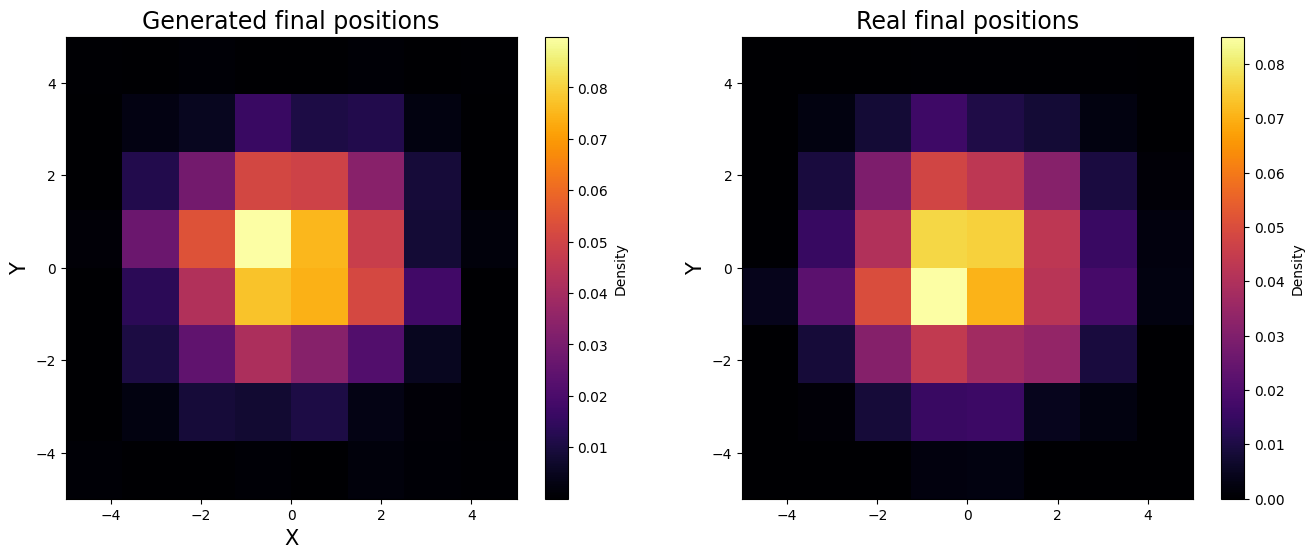

In [63]:
# Crear la figura con dos subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Primer subplot: Mapa de densidad de posiciones originales
im1 = axs[0].imshow(t.T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
axs[0].set_title('Generated final positions', fontsize=17)
axs[0].set_xlabel('X', fontsize=15)
axs[0].set_ylabel('Y', fontsize=15)
fig.colorbar(im1, ax=axs[0], label='Density')

# Segundo subplot: Mapa de densidad de posiciones normalizadas
im2 = axs[1].imshow(probs_map[0].T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
axs[1].set_title('Real final positions', fontsize=17)
axs[1].set_ylabel('X', fontsize=15)
axs[1].set_ylabel('Y', fontsize=15)
fig.colorbar(im2, ax=axs[1], label='Density')

plt.show()

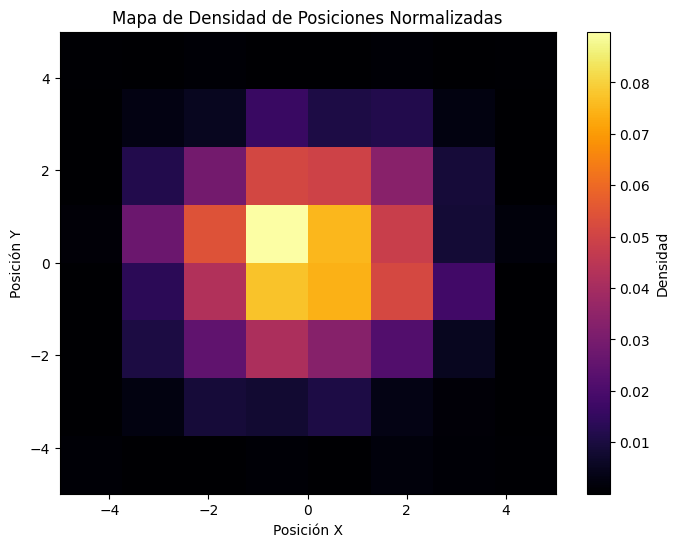

In [21]:

# Visualizar la densidad
plt.figure(figsize=(8, 6))
plt.imshow(t.T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='Densidad')
plt.title('Mapa de Densidad de Posiciones Normalizadas')
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
#plt.grid(True)
plt.show()


# Simulations

In [26]:
# Trained params
for param in generator.parameters():
    trained_params = param

trained_params

Parameter containing:
tensor([ 0.7661, -0.1948,  0.9262,  0.5783, -0.5445,  0.5276,  0.3731,  0.2854,
         0.5968,  0.7586,  0.6876,  0.4827, -0.1666,  0.5314,  0.4878,  0.0830,
         0.7960,  0.5393,  0.7711,  0.5432,  1.0416,  1.1103,  0.4825,  0.7765,
        -0.5501,  1.2735, -0.1010,  0.0062,  0.7039,  1.1041,  0.9983, -0.2522,
         0.5907,  1.3130,  1.2381,  0.4332], requires_grad=True)

In [27]:
dev = qml.device("default.qubit", wires=n_qubits, shots=2000)

@qml.qnode(dev)
def random_walk_simulator(weights):

    weights = weights.reshape(q_depth, n_qubits)

    # Initialise latent vectors
    for i in range(n_qubits):
        qml.Hadamard(wires=i)

    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][y], wires=y)

        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])

        #qml.CZ(wires=[5, 0])

        qml.Barrier(wires=list(range(n_qubits)), only_visual=True)

    return qml.probs(wires=list(range(n_qubits)))



In [85]:
real_random_walks = random_walk(8000, 5).T
real_random_walks = calculate_probabilities(real_random_walks, 2000, 8, 5)
real_random_walks.shape

(4, 8, 8)

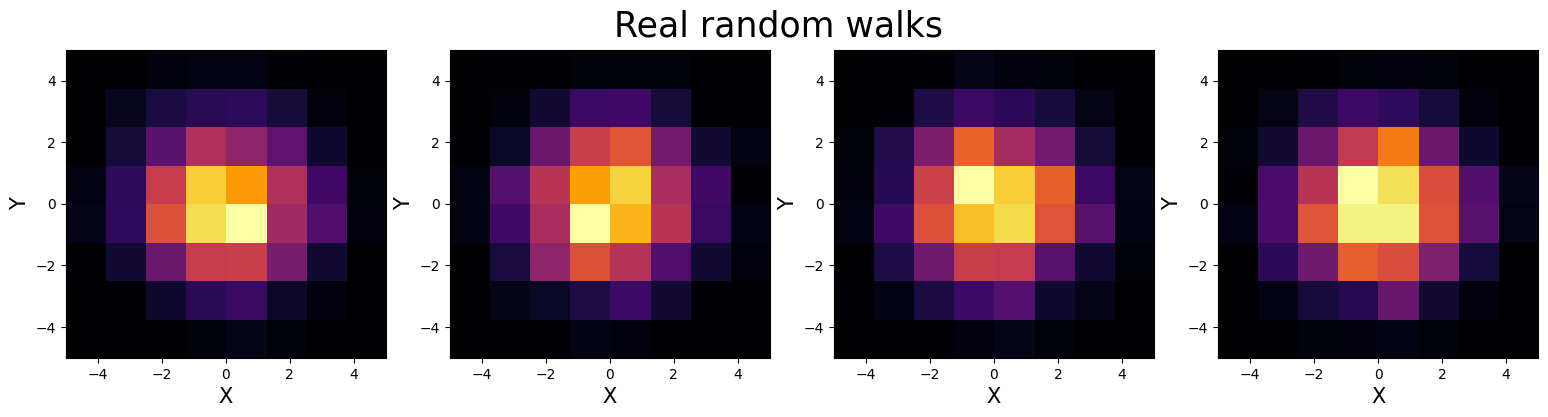

In [87]:
fig, axs = plt.subplots(1, 4, figsize=(19, 4))
real_random_walks = random_walk(8000, 5).T
real_random_walks = calculate_probabilities(real_random_walks, 2000, 8, 5)

for i in range(4):

    axs[i].imshow(real_random_walks[i].T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
    axs[i].set_xlabel('X', fontsize=15)
    axs[i].set_ylabel('Y', fontsize=15)

plt.suptitle("Real random walks", fontsize=25)
plt.show()

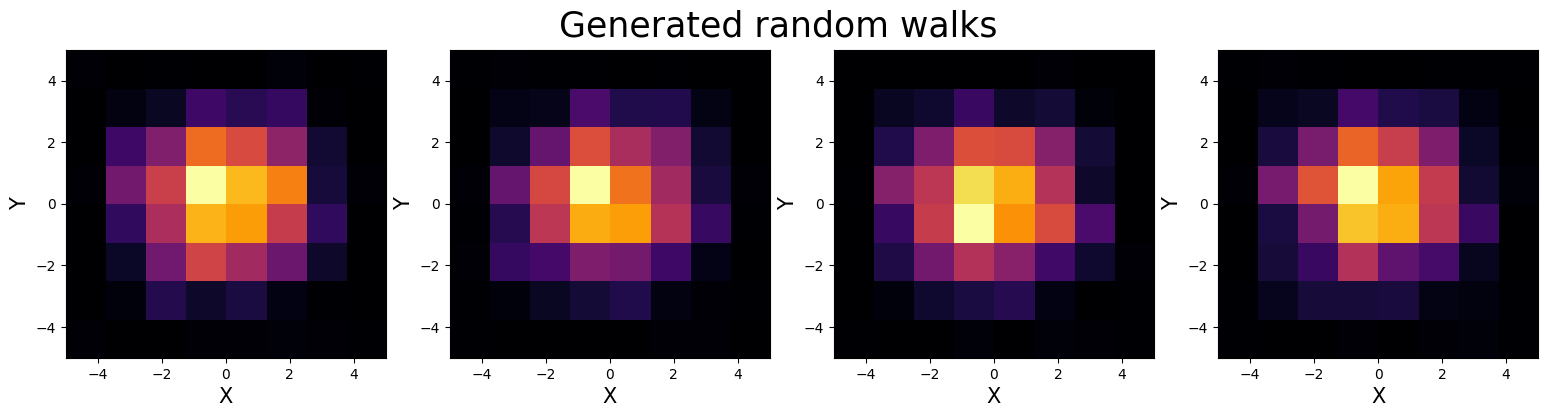

In [93]:
fig, axs = plt.subplots(1, 4, figsize=(19, 4))

for i in range(4):
    gen_random_walks = random_walk_simulator(trained_params).detach().numpy().reshape(8, 8)

    axs[i].imshow(gen_random_walks.T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
    axs[i].set_xlabel('X', fontsize=15)
    axs[i].set_ylabel('Y', fontsize=15)

plt.suptitle("Generated random walks", fontsize=25)
plt.show()



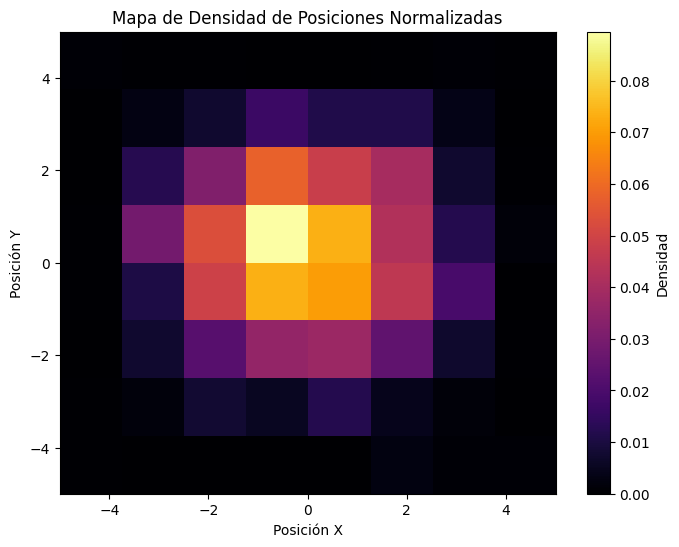

In [57]:
random_walks = random_walk_simulator(trained_params).detach().numpy().reshape(8, 8)

# Visualizar la densidad
plt.figure(figsize=(8, 6))
plt.imshow(random_walks.T, extent=[-5, 5, -5, 5], origin='lower', cmap='inferno', aspect='auto')
plt.colorbar(label='Densidad')
plt.title('Mapa de Densidad de Posiciones Normalizadas')
plt.xlabel('Posición X')
plt.ylabel('Posición Y')
#plt.grid(True)
plt.show()
